## 1. Get the image data

In [22]:
import os
import pickle
import pandas as pd

data_file = '../Dataset/image_data'
with open(data_file, 'rb') as inFile:
    data = pickle.load(inFile)

train_set = pd.read_csv('../Dataset/image_data_train.csv')
test_set = pd.read_csv('../Dataset/image_data_test.csv')
test_set.head()

,Unnamed: 0,id,name,image_url,rating,review_count,price
0,0,_PVqCO2zQSNHVNTQEFqodg,Bojangles,https://s3-media3.fl.yelpcdn.com/bphoto/BPRRsb...,3.5,28,1
1,1,niEBE4lkte3vWLwOrgFyhA,Dairy Queen,https://s3-media2.fl.yelpcdn.com/bphoto/e3CuWg...,5.0,1,1
2,2,X59w9MNYP5pyzAQnMOPVUA,Hunan Garden,https://s3-media2.fl.yelpcdn.com/bphoto/utyWIB...,4.5,56,2
3,3,tw81EgOe63O7rWbT28Wj0Q,Cafesano,https://s3-media4.fl.yelpcdn.com/bphoto/m6SiJK...,4.0,424,2
4,4,vKd1JL_7Er3utZSgmOwmSw,TBS Messhall,https://s3-media4.fl.yelpcdn.com/bphoto/NX4-Mh...,3.0,3,1


In [2]:
from PIL import Image
import numpy as np

img_dir_old='../Dataset/Image'
files = os.listdir(img_dir_old)

img_dir='../Dataset/img'
train_path = os.path.join(img_dir, 'train')
test_path = os.path.join(img_dir, 'test')

for i in range(1, 5):
    if not os.path.exists(os.path.join(train_path, str(i))):
        os.makedirs(os.path.join(train_path, str(i)))
    if not os.path.exists(os.path.join(test_path, str(i))):
        os.makedirs(os.path.join(test_path, str(i)))
    

train_id_list = []
test_id_list = []
for file in files:
    fname = file[:-4]
    for i in range(len(data)):
        if fname == data.iloc[i,0]:
            if fname in train_set.id.values:
                train_id_list.append(fname)
                img = Image.open(os.path.join(img_dir_old, file))
                img.save(os.path.join(train_path+'/'+str(data.iloc[i,3]), file))
            elif fname in test_set.id.values:
                test_id_list.append(fname)
                img = Image.open(os.path.join(img_dir_old, file))
                img.save(os.path.join(test_path+'/'+str(data.iloc[i,3]), file))

In [3]:
print('Train_set size:',len(train_id_list))
print('Test_set size:',len(test_id_list))

Train_set size: 3891
Test_set size: 973


## 2. Train the image classifier

In [4]:
# Instantiate the VGG16 convolutional base
from keras.applications import VGG16

conv_base=VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
# weights: specify which weight checkpoint to initialize the model from
# include_top: include or not the densely-connected classifier on top of the network
# input_shape: the shape of image tensors that will feed to the network

conv_base.summary()

D:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
# Extract features using the pretrained convolutional base
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

img_dir='../Dataset/img'
train_path = os.path.join(img_dir, 'train')
test_path = os.path.join(img_dir, 'test')

datagen=ImageDataGenerator(rescale=1./255)
batch_size=100

def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count, 4, 4, 512))
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(directory,target_size=(150,150),batch_size=batch_size,class_mode='sparse')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch=conv_base.predict(inputs_batch)
        if len(features_batch)!=batch_size:
            features[i*batch_size:i*batch_size+len(features_batch)]=features_batch
            labels[i*batch_size:i*batch_size+len(features_batch)]=labels_batch
        else:
            features[i*batch_size:(i+1)*batch_size]=features_batch
            labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break
    return features, labels

train_features, train_labels=extract_features(train_path, len(train_id_list))
test_features, test_labels=extract_features(test_path, len(test_id_list))

Found 3891 images belonging to 4 classes.
Found 973 images belonging to 4 classes.


In [6]:
# Flatten the features
train_features = np.reshape(train_features, (len(train_id_list),4*4*512))
test_features = np.reshape(test_features, (len(test_id_list),4*4*512))

In [7]:
# Convert the labels into one-hot vectors
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories='auto')
enc.fit(train_labels.reshape(-1, 1))
y_train = enc.transform(train_labels.reshape(-1, 1))
y_test = enc.transform(test_labels.reshape(-1, 1))
y_train = y_train.toarray()
y_test = y_test.toarray()

In [23]:
# combine the image features with numerical data
train_set = train_set.set_index('id')
test_set = test_set.set_index('id')
X_train_num = train_set.loc[train_id_list, :]
X_test_num = test_set.loc[test_id_list, :]
X_train_num = X_train_num[['rating','review_count']]
X_test_num = X_test_num[['rating','review_count']]
X_train = np.hstack((X_train_num.values, train_features))
X_test = np.hstack((X_test_num.values, test_features))

In [25]:
# Train a densely-connected neural network classifier
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=['acc'])
history=model.fit(train_features, y_train, epochs=10, batch_size=32, validation_split=0.1)
model.save('models/image_clf.h5')

Train on 3501 samples, validate on 390 samples
Epoch 1/10
3501/3501 [==============================] - 5s 1ms/step - loss: 1.0627 - acc: 0.5033 - val_loss: 0.7910 - val_acc: 0.6154
Epoch 2/10
3501/3501 [==============================] - 5s 2ms/step - loss: 0.8866 - acc: 0.5567 - val_loss: 0.7571 - val_acc: 0.6333
Epoch 3/10
3501/3501 [==============================] - 5s 2ms/step - loss: 0.8541 - acc: 0.5681 - val_loss: 0.7522 - val_acc: 0.6410
Epoch 4/10
3501/3501 [==============================] - 5s 2ms/step - loss: 0.8437 - acc: 0.5844 - val_loss: 0.7449 - val_acc: 0.6385
Epoch 5/10
3501/3501 [==============================] - 5s 2ms/step - loss: 0.8243 - acc: 0.6093 - val_loss: 0.7403 - val_acc: 0.6385
Epoch 6/10
3501/3501 [==============================] - 5s 2ms/step - loss: 0.8016 - acc: 0.6133 - val_loss: 0.7358 - val_acc: 0.6333
Epoch 7/10
3501/3501 [==============================] - 5s 1ms/step - loss: 0.8048 - acc: 0.6130 - val_loss: 0.7355 - val_acc: 0.6282
Epoch 8/10
3501

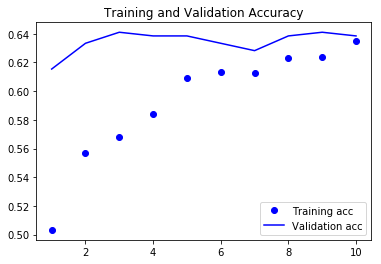

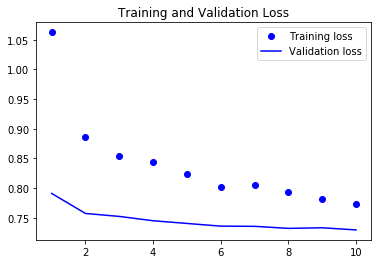

In [26]:
# Plot the results
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

target_names = ['$', '$$', '$$$', '$$$$']
y_test = np.argmax(y_test, axis=1)
y_pred = model.predict(test_features)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))
print('Test Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           $       0.56      0.41      0.47       353
          $$       0.66      0.81      0.73       585
         $$$       0.00      0.00      0.00        33
        $$$$       0.00      0.00      0.00         2

   micro avg       0.63      0.63      0.63       973
   macro avg       0.30      0.30      0.30       973
weighted avg       0.60      0.63      0.61       973

Test Accuracy: 0.6341212744090442


C:\Users\think\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
outs = pd.DataFrame(columns=['id','y_pred'])
outs['id']=test_id_list
outs['y_pred']=y_pred+1
outs.to_csv('../Dataset/image_preds.csv')